# Note: Please "Copy" this notebook before you work on it !!!!
In File   ->   Save a copy in Drive

# 1.introduction

This project is about car classification for [stanford car dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html). The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

![](https://ai.stanford.edu/~jkrause/cars/class_montage.jpg)

# Note
use the following keras version for fixed batch norm in transfer learning.

In [1]:
!pip install -U --force-reinstall --no-dependencies  git+https://github.com/datumbox/keras@bugfix/trainable_bn

  Cloning https://github.com/datumbox/keras (to revision bugfix/trainable_bn) to /tmp/pip-req-build-mca_haxf
  Running command git clone -q https://github.com/datumbox/keras /tmp/pip-req-build-mca_haxf
  Running command git checkout -b bugfix/trainable_bn --track origin/bugfix/trainable_bn
  Switched to a new branch 'bugfix/trainable_bn'
  Branch 'bugfix/trainable_bn' set up to track remote branch 'bugfix/trainable_bn' from 'origin'.
  Created wheel for Keras: filename=Keras-2.2.4-cp36-none-any.whl size=311046 sha256=5136b31811505f1cf3d4f24ec6dc164dd263311baa07e055aa1f60eb40b70e1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-8w17al2q/wheels/36/5d/50/99c268bf64c1394c4f5b743164e4e515ab30290a523595ac47
Successfully built Keras
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [2]:
!pip install albumentations > /dev/null
!git clone https://github.com/qubvel/efficientnet.git
!pip install console_progressbar

Cloning into 'efficientnet'...
remote: Enumerating objects: 280, done.
remote: Total 280 (delta 0), reused 0 (delta 0), pack-reused 280
Receiving objects: 100% (280/280), 824.67 KiB | 6.29 MiB/s, done.
Resolving deltas: 100% (156/156), done.
  Created wheel for console-progressbar: filename=console_progressbar-1.1.2-cp36-none-any.whl size=4141 sha256=972f760a30f6457a6fe96d6f28a413162b1a89121b2c80ea8947a3111a47490d
  Stored in directory: /root/.cache/pip/wheels/35/48/4c/dfcbbd70b7a1690c7113e01fa2201a809203078d96de82b900
Successfully built console-progressbar


# 2.Import & read data

## 2.1 mount google drive to colab

In [3]:
# mount goolge drive to colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 2.2 Copy file from google drive to colab

In [0]:
# import scipy.io
# import numpy as np

# cars_meta = scipy.io.loadmat('drive/My Drive/DL/car_dataset/devkit/cars_meta.mat')
# class_names = cars_meta['class_names']
# class_names = np.transpose(class_names)


# 3.Build model

## 3.1 Load packages

The keras and tensorflow have been pre-installled on colab.

In [4]:
from keras.preprocessing import image
from keras.applications import vgg16
from keras.applications import vgg19
from keras.applications import resnet50
from keras.applications import inception_v3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Model, Sequential
from keras import optimizers
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
# import argparse
from time import time

from skimage import exposure, color

from keras import backend as K
# K.common.image_dim_ordering()
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [0]:
from keras.layers.pooling import MaxPooling2D,AveragePooling2D
import efficientnet.efficientnet.keras as efn 


## 3.2 Initalize model
In this step, we will initalize our architecture. We use predefined architectures such as resnet50/vgg19. I use EfficientNet to get best performance model.

In [0]:
def init_model(train_dir, val_dir, batch_size=32, model_name=None, num_class=None, img_size=224):
    """
    initialize cnn model and training and validation data generator
    parms:
        args: parsed commandline arguments
    return:
        model: initialized model
        train_generator: training data generator
        validation_generator: validation data generator
    """
    

    print('loading the model and the pre-trained weights...')  

    # load base model
    if model_name == 'vgg19':
        base_model = vgg19.VGG19(include_top=False, weights='imagenet', input_shape = (img_size, img_size, 3)) # need specify input_shape
        # this preprocess_input is the default preprocess func for given network, you can change it or implement your own 
        # use inception_v3 preprocess for vgg16, it seems that it works better than vgg16.preprocess_input
        preprocess_input = vgg19.preprocess_input
    
    elif model_name == 'resnet50':
        base_model = resnet50.ResNet50(include_top=False, weights='imagenet', input_shape = (img_size, img_size, 3))
        preprocess_input = resnet50.preprocess_input
    
    elif model_name == 'inception_v3':
        base_model = inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape = (img_size, img_size, 3))
        preprocess_input = inception_v3.preprocess_input
        
    elif model_name == 'efn':
        base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape = (img_size, img_size, 3))
    
    # initalize training image data generator'
    # you can also specify data augmentation here
    train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.1,
        height_shift_range=0.1,
#         samplewise_center=True,
#         samplewise_std_normalization=True,
        rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.5, 1.5],
        horizontal_flip=True
#         preprocessing_function=preprocess_input
        )

    # initalize validation image data generator
    # you can also specify data augmentation here
    validation_datagen = image.ImageDataGenerator(
#         samplewise_center=True,
#         samplewise_std_normalization=True,
        rescale=1./255
#         preprocessing_function=preprocess_input # preprocess_input
        )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')     

    validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        # color_mode='grayscale',  # 'rgb'
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')

    # fix base_model layers
#     for layer in base_model.layers:
#         layer.trainable = False

    # added some customized layers for your own data
    x = base_model.output
    if model_name == 'vgg19':
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        # x = Flatten(name='flatten')(x)
        # x = Dense(512, activation='relu', name='fc1-pretrain')(x)
        x = Dense(256, activation='relu', name='fc2-pretrain')(x)
        x = Dropout(0.3, name='dropout')(x)
    elif model_name == 'resnet50':
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        x = Dense(256, activation='relu', name='fc256')(x)
        x = Dropout(0.3, name='dropout')(x)
    elif model_name == 'inception_v3':
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu')(x)
        x = Dense(512, activation='relu')(x)
    elif model_name == 'efn':
        x = AveragePooling2D((5, 5), name='avg_pool')(x)
        x = Flatten()(x)
        x = Dropout(0.3, name='dropout')(x)
    
    # added softmax layer
    predictions = Dense(num_class, activation='softmax', name='predictions')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
#     sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
    adam = optimizers.Adam(lr=0.0005)
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

    return model, train_generator, validation_generator

## 3.3 train model
This part defines the function to train our model. We can specify the training parameters such as number of epochs, optimizers, and etc here.

In [0]:
def train(model, train_generator, validation_generator, batch_size=32, model_name=None, num_class=None, epochs=30):
    """
    train the model
    parms:
        model: initialized model
        train_generator: training data generator
        validation_generator: validation data generator
        args: parsed command line arguments
    return:
    """
    # define number of steps/iterators per epoch
    stepsPerEpoch = train_generator.samples / batch_size
    validationSteps= validation_generator.samples / batch_size

    # save the snapshot of the model to local drive
    pretrain_model_name = 'pretrained_{}_{}_{}.h5'.format(model_name, num_class, epochs)
    # visualize the training process
    tensorboard = TensorBoard(log_dir="logs/{}_pretrain_{}".format(model_name, time()), histogram_freq=0, write_graph=True)
    checkpoint = ModelCheckpoint(pretrain_model_name, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    earlystopping = EarlyStopping(monitor='acc', patience=5)
    callbacks_list = [checkpoint, tensorboard, earlystopping]

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=stepsPerEpoch,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data = validation_generator,
        validation_steps=validationSteps)
    return history

## 3.4 Fine-tune model
This part defines the function to fine-tune the pre-trained model on our datset. If you do not have enough data, you may consider fine-tune less layers.

In [0]:
 def fine_tune(model, train_generator, validation_generator, batch_size=32, model_name=None, num_class=None, epochs=50):
    """
    fine tune the model
    parms:
        model: initialized model
        train_generator: training data generator
        validation_generator: validation data generator
        args: parsed command line arguments
    return:
    """
    # for specific architectures, define number of trainable layers
#     if model_name in ('vgg19','efn'):
#         trainable_layers = 6
        
#         for layer in model.layers[:-1*trainable_layers]:
#             layer.trainable = False

#         for layer in model.layers[-1*trainable_layers:]:
#             layer.trainable = True


    finetune_model_name = 'finetuned_{}_{}_{}.h5'.format(model_name, num_class, epochs)
    tensorboard = TensorBoard(log_dir="logs/{}_finetune_{}".format(model_name, time()), histogram_freq=0, write_graph=True)
    checkpoint = ModelCheckpoint(finetune_model_name, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    earlystopping = EarlyStopping(monitor='acc', patience=5)
    callbacks_list = [checkpoint, tensorboard, earlystopping]
    
    
    model.compile(optimizer=optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#     model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True),metrics=["accuracy"])

    stepsPerEpoch = train_generator.samples / batch_size
    validationSteps= validation_generator.samples / batch_size
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=stepsPerEpoch,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data = validation_generator,
        validation_steps=validationSteps)
    return history

# 4.Experiment

## 4.1.Train/fine-tune model
We can start to train and fine-tune our model here.

In [9]:
model_n = "efn"
train_path = 'drive/My Drive/DL/car_dataset/train'
val_path = 'drive/My Drive/DL/car_dataset/test'
num_class = 196
img_size = 224
# num_class = len(os.listdir(train_path))

# initialize model
model, train_generator, validation_generator = init_model(train_dir=train_path, model_name=model_n, val_dir=val_path, num_class=num_class, img_size=img_size)
# pretrain model
train(model, train_generator, validation_generator, num_class=num_class, model_name=model_n, epochs=15)
# fine-tune model   
history = fine_tune(model, train_generator, validation_generator, num_class=num_class, model_name=model_n, epochs=50)

loading the model and the pre-trained weights...











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
16809984/16804768 [==============================] - 0s 0us/step
Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Epoch 1/15
255/254 [==============================] - 5572s 22s/step - loss: 4.3994 - acc: 0.1149 - val_loss: 2.6226 - val_acc: 0.3445

Epoch 00001: val_acc improved from -inf to 0.34448, saving model to pretrained_efn_196_15.h5

Epoch 2/15
255/254 [==============================] - 345s 1s/step - loss: 1.9569 - acc: 0.4966 - val_loss: 1.5611 - val_acc: 0.5656

Epoch 00002: val_acc improved from 0.34448 to 0.56560, saving model to pretrained_efn_196_15.h5
Epoch 3/15
255/254 [==============================] - 347s 1s/step - loss: 1.0816 - acc: 0.6944 - val_loss: 1.

## 4.2 Results

#### save and reload model (we can load saved model to do next steps)

In [0]:
model.save_weights(model_n+'_weights.h5')
with open(model_n+'_trans.json','w') as f:
  f.write(model.to_json())

In [0]:
# you can pass this cell if you don't use loaded model

from keras.models import model_from_json
with open('drive/My Drive/DL/efn_trans.json','r') as f:
  model = model_from_json(f.read())

model.load_weights('drive/My Drive/DL/efn_weights.h5')












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




#### initialize corresponding generator for loaded model

In [11]:
# you can pass this cell if you don't use loaded model

model_n = "efn"
train_path = 'drive/My Drive/DL/car_dataset/train'
val_path = 'drive/My Drive/DL/car_dataset/test'
num_class = 196
img_size = 224
# num_class = len(os.listdir(train_path))

# initialize model
_, train_generator, validation_generator = init_model(train_dir=train_path, model_name=model_n, val_dir=val_path, num_class=num_class, img_size=img_size)

model.compile(optimizer=optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

loading the model and the pre-trained weights...
Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


### 4.2.1 Accuracy

In [12]:
scores = model.evaluate_generator(validation_generator, verbose=1, steps=len(validation_generator))
print("Validation accuracy = ", scores[1])

252/252 [==============================] - 97s 384ms/step
Validation accuracy =  0.8589727646037575


### 4.2.2 Classification report

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# test_datagen = image.ImageDataGenerator(
#     preprocessing_function=vgg19.preprocess_input # preprocess_input
#     )

test_datagen = image.ImageDataGenerator(
    rescale=1./255
    )

test_generator = test_datagen.flow_from_directory(
    "drive/My Drive/DL/car_dataset/test",
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,    # keep data in same order as labels
    class_mode='categorical')# only data, no labels

true_labels = test_generator.classes

predicted_label_probs = model.predict_generator(test_generator, verbose=1,steps=len(test_generator))
predicted_labels = np.argmax(predicted_label_probs, axis=1)
# predicted_labels 

Found 8041 images belonging to 196 classes.
8041/8041 [==============================] - 284s 35ms/step


In [0]:
label_map = test_generator.class_indices
inverse_label_map = {val:int(key) for key, val in label_map.items()}
# print(inverse_label_map)

In [15]:
print(classification_report(true_labels, predicted_labels))
# print("Accuracy = ", accuracy_score(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        44
           1       0.78      0.85      0.81        33
           2       1.00      0.88      0.94        33
           3       0.95      0.83      0.89        42
           4       0.86      0.95      0.90        39
           5       0.76      0.79      0.77        39
           6       0.81      0.60      0.68        42
           7       1.00      0.93      0.96        43
           8       0.95      0.90      0.92        41
           9       0.92      0.82      0.87        44
          10       0.88      0.95      0.91        44
          11       0.95      0.95      0.95        44
          12       0.81      0.89      0.85        38
          13       0.98      1.00      0.99        43
          14       0.95      0.93      0.94        42
          15       0.95      0.82      0.88        45
          16       1.00      0.93      0.96        42
          17       0.91    

#### load class names (you can check classes by printing 'class_names')

In [0]:
import scipy.io
import numpy as np

cars_meta = scipy.io.loadmat('drive/My Drive/DL/car_dataset/devkit/cars_meta.mat')
class_names = cars_meta['class_names']
class_names = np.transpose(class_names)


### 4.2.3 Prediction with visualization

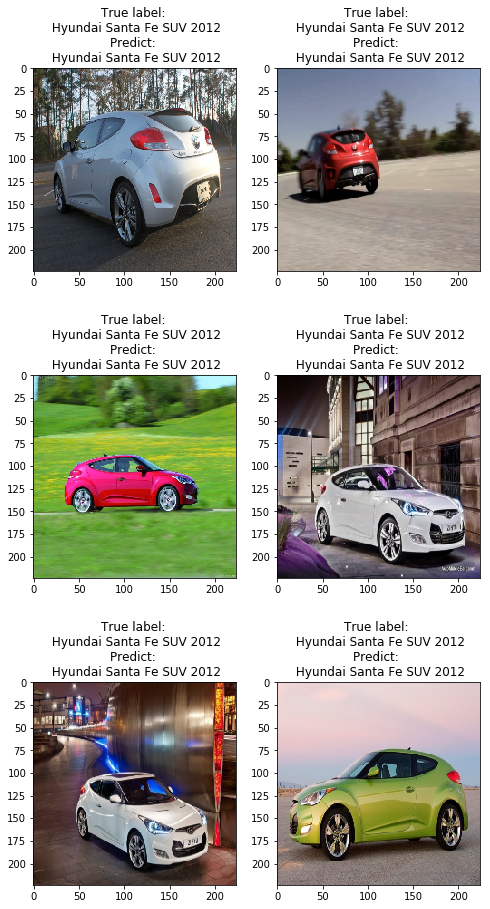

In [62]:
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
# from efficientnet.keras import EfficientNetB0
from efficientnet.efficientnet.keras import center_crop_and_resize, preprocess_input
from skimage.io import imread
import cv2
import glob

chose_class = 130
file = glob.glob("drive/My Drive/DL/car_dataset/test/%d/*.jpg" %(chose_class))
fig = plt.figure(figsize=(8, 16))
rows, cols = 3, 2
ax = []

for idx,img_path in enumerate(file[:6]):
  bgr_img = cv2.imread(img_path)
  rgb_img = cv2.resize(cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)/255,(224,224))
  rgb_img = np.expand_dims(rgb_img, 0)
  
  pred = model.predict(rgb_img)
  pred_label = np.argmax(pred,axis=1)
  
  ax.append( fig.add_subplot(rows, cols, idx+1) )
  ax[-1].set_title("True label: \n %s" %(str(class_names[chose_class][0][0]))+'\n'+
                  "Predict: \n %s" %(str(class_names[inverse_label_map[pred_label[0]]][0][0])))  # set title
  plt.imshow(rgb_img[0])


#   pred = model.predict(rgb_img)
#   pred_label = np.argmax(pred,axis=1)
#   print(pred_label)
#   print(class_names[inverse_label_map[pred_label[0]]][0][0])

plt.show()

#### Use self-loaded image to see model performance

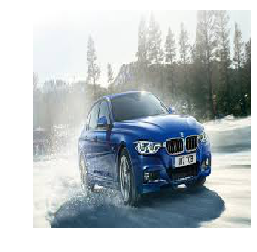

predict: BMW 3 Series Wagon 2012


In [72]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.applications.imagenet_utils import preprocess_input


def load_image(img_path, show=True):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.


    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor
  
  
img_path = "drive/My Drive/DL/p4.jpeg"
new_image = load_image(img_path)

# check prediction
pred = model.predict(new_image)
pred_label = np.argmax(pred,axis=1)
print("predict:", class_names[inverse_label_map[pred_label[0]]][0][0])


### 4.2.4 Visualize confusion matrix

In [0]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.97222222 0.         0.02777778
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.05714286 0.88571429
  0.05714286 0.         0.         0.        ]
 [0.         0.         0.         0.02857143 0.02857143 0.22857143
  0.71428571 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.      

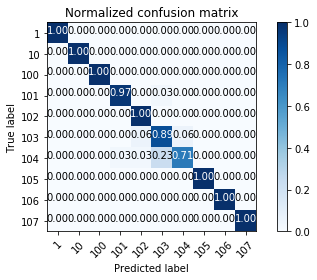

In [19]:
cnf_matrix = confusion_matrix(true_labels, predicted_labels)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=list(label_map.keys()),
#                       title='Confusion matrix, without normalization')


# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix[:10,:10], classes=list(label_map.keys())[:10], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 4.2.5 Visualize training history

In [0]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

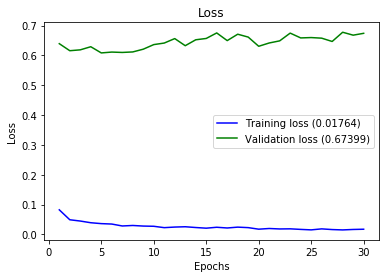

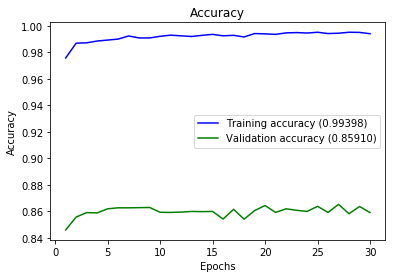

In [21]:
plot_history(history)

In [0]:
# from sklearn.metrics import recall_score, classification_report, auc, roc_curve
# cm = confusion_matrix(true_labels, predicted_labels)
# print(cm)


# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [0]:
# predicted_labels